In [2]:
# ========================
# 1. Importación de librerías y carga de datos
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn: Modelos y preprocesamiento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans

# Modelos adicionales: XGBoost, LightGBM y CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ========================
# 2. Carga de los datos
# ========================

# Cargar datasets de entrenamiento y prueba
train_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Train.csv"
test_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Test.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Exploración inicial de los datos
print(" Información del dataset de entrenamiento:")
print(df.info())
print("\n Primeras filas del dataset de entrenamiento:")
print(df.head())

print("\n Información del dataset de test:")
print(test_df.info())
print("\n Primeras filas del dataset de test:")
print(test_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Train.csv'

In [ ]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A



 Valores nulos en dataset de entrenamiento:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

 Valores nulos en dataset de test:
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


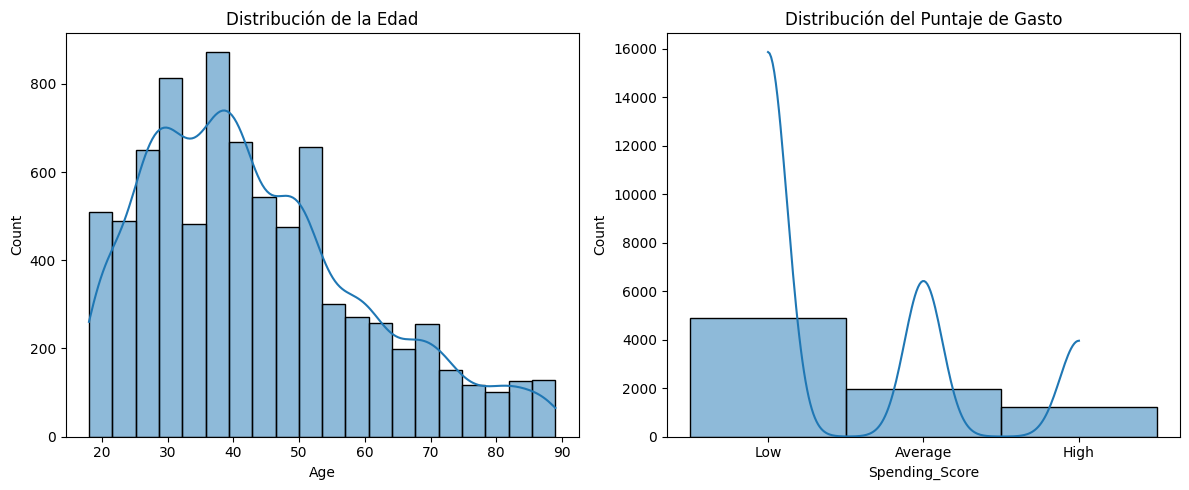

In [ ]:
# ========================
# 3. Análisis de valores nulos y distribuciones
# ========================

# Verificar valores nulos en cada dataset
print("\n Valores nulos en dataset de entrenamiento:")
print(df.isnull().sum())

print("\n Valores nulos en dataset de test:")
print(test_df.isnull().sum())

# Visualización de la distribución de algunas variables clave
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribución de la Edad')

sns.histplot(df['Spending_Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribución del Puntaje de Gasto')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Primero definimos el DataPreprocessor
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_features = ['Age', 'Work_Experience', 'Family_Size']
        self.cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        
        # Debug print
        print("Columns in input data:", X_copy.columns.tolist())
        
        # Handle missing values
        # Numerical: median imputation
        for col in self.num_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].median(), inplace=True)
        
        # Categorical: mode imputation
        for col in self.cat_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].mode()[0], inplace=True)
        
        # Add feature engineering
        X_copy['Age_Group'] = pd.cut(X_copy['Age'], 
                                    bins=[0, 25, 35, 50, 65, 100],
                                    labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
        
        # Convert Spending_Score to numeric
        spending_map = {'Low': 1, 'Average': 2, 'High': 3}
        X_copy['Spending_Power'] = X_copy['Spending_Score'].map(spending_map)
        
        # Debug print
        print("Columns after preprocessing:", X_copy.columns.tolist())
        
        return X_copy

In [ ]:
#2
# Transformer que realiza:
# - Escalado de los datos (para clustering)
# - Búsqueda del número óptimo de clusters usando silhouette_score
# - Cálculo de los centros de los clusters y, basándose en los nombres de las columnas, sugiere una etiqueta para cada cluster
# - Solicita al usuario, para cada cluster, ingresar una etiqueta (presionando Enter se acepta la sugerencia)
    
class ClusteringAndMapping(BaseEstimator, TransformerMixin):
    def __init__(self, k_range=range(2, 11), random_state=42):
        self.k_range = k_range
        self.random_state = random_state

    def fit(self, X, y=None):
        # Si X es DataFrame, se extraen los nombres de las columnas y se obtiene la matriz numérica
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            X_numeric = X.values
        else:
            self.feature_names_ = None
            X_numeric = X

        # Escalado de datos
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X_numeric)

        best_score = -1
        best_k = None
        best_model = None

        # Se recorre el rango de k para encontrar el que maximice el silhouette_score
        for k in self.k_range:
            model = KMeans(n_clusters=k, random_state=self.random_state)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_model = model

        self.best_k_ = best_k
        self.best_model_ = best_model
        print("Número óptimo de clusters encontrado:", best_k)

        # Calcular centros de clusters (en espacio escalado)
        self.centers_ = self.best_model_.cluster_centers_
        
        # Sugerir una etiqueta para cada cluster:
        self.mapping_ = {}
        print("\n--- Sugerencias de Etiquetas para cada Cluster ---")
        for cluster in range(self.best_k_):
            center = self.centers_[cluster]
            # Si se tienen nombres de columnas, se busca la característica con mayor valor absoluto
            if self.feature_names_ is not None:
                idx = np.argmax(np.abs(center))
                feature = self.feature_names_[idx]
                if center[idx] >= 0:
                    suggestion = f'Alto {feature}'
                else:
                    suggestion = f'Bajo {feature}'
            else:
                suggestion = f'Cluster {cluster}'
            # Solicitar input interactivo al usuario
            user_input = input(f"Para el cluster {cluster} se sugiere: '{suggestion}'. Ingrese la etiqueta deseada (o presione Enter para aceptar): ")
            self.mapping_[cluster] = user_input if user_input.strip() != "" else suggestion

        print("\nMapping final:", self.mapping_)
        return self

    def transform(self, X):
        # Se asegura de aplicar el mismo escalado
        if hasattr(X, 'columns'):
            X_numeric = X.values
        else:
            X_numeric = X
        X_scaled = self.scaler_.transform(X_numeric)
        # Se predicen los clusters usando el modelo óptimo encontrado
        cluster_labels = self.best_model_.predict(X_scaled)
        # Se mapea cada cluster a la etiqueta definida por el usuario o sugerida
        mapped_labels = np.array([self.mapping_[label] for label in cluster_labels])
        return mapped_labels
    

In [ ]:
def evaluate_clusters(X, labels, centers):
    # Silhouette score
    sil_score = silhouette_score(X, labels)
    
    # Davies-Bouldin score
    from sklearn.metrics import davies_bouldin_score
    db_score = davies_bouldin_score(X, labels)
    
    # Calculate cluster sizes
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    # Feature importance per cluster
    feature_importance = pd.DataFrame(
        centers,
        columns=X.columns
    ).apply(lambda x: np.abs(x - x.mean()) / x.std())
    
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Score: {db_score:.3f}")
    print("\nCluster Sizes:")
    print(cluster_sizes)
    print("\nTop Features per Cluster:")
    for i in range(len(centers)):
        top_features = feature_importance.iloc[i].nlargest(3)
        print(f"\nCluster {i} - Top Features:")
        print(top_features)

def analyze_cluster_profiles(df, labels):
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels
    
    profiles = []
    for cluster in np.unique(labels):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
        profile = {
            'Cluster': cluster,
            'Size': len(cluster_data),
            'Avg_Age': cluster_data['Age'].mean(),
            'Spending_Distribution': cluster_data['Spending_Score'].value_counts(normalize=True),
            'Top_Professions': cluster_data['Profession'].value_counts().nlargest(3),
            'Married_Ratio': (cluster_data['Ever_Married'] == 'Yes').mean(),
            'Graduated_Ratio': (cluster_data['Graduated'] == 'Yes').mean()
        }
        profiles.append(profile)
    
    return profiles

def analyze_feature_importance(pipeline, X):
    # Obtener datos transformados
    preprocessed_data = pipeline.named_steps['preprocessor'].transform(X)
    feature_selected_data = pipeline.named_steps['feature_selector'].transform(preprocessed_data)
    
    # Obtener nombres de características
    numeric_features = ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power']
    categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group']
    
    # Obtener nombres de características después de one-hot encoding
    cat_encoder = pipeline.named_steps['feature_selector'].named_transformers_['cat']
    categorical_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
    
    # Combinar nombres de características
    all_features = numeric_features + categorical_features_encoded.tolist()
    
    # Obtener centroides de clusters
    cluster_centers = pipeline.named_steps['clustering_mapping'].best_model_.cluster_centers_
    
    # Calcular importancia de características por cluster
    for i, center in enumerate(cluster_centers):
        print(f"\nCluster {i} - Características más importantes:")
        # Calcular la distancia desde la media global
        importance = np.abs(center - np.mean(feature_selected_data, axis=0))
        # Obtener top 5 características
        top_features_idx = np.argsort(importance)[-5:]
        for idx in top_features_idx[::-1]:
            print(f"{all_features[idx]}: {importance[idx]:.3f}")

Original columns: ['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation']
Columns after dropping ID and Segmentation: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']
Número óptimo de clusters encontrado: 6

--- Sugerencias de Etiquetas para cada Cluster ---

Mapping final: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ev

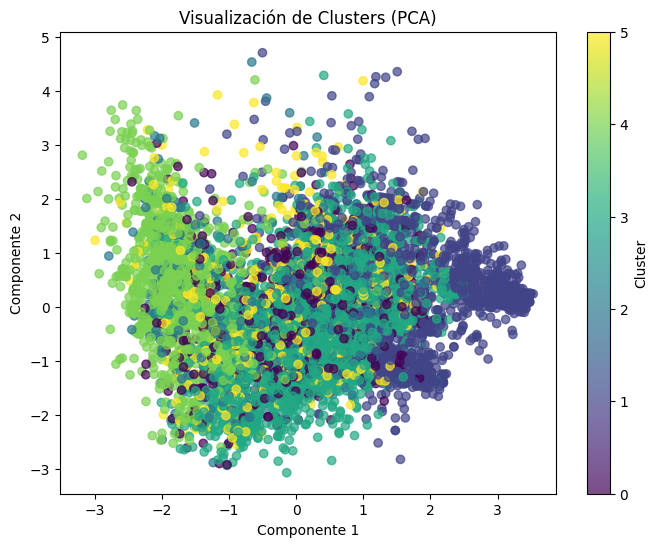

Silhouette Score: 0.102

Cluster 0:
Tamaño: 914 clientes
Edad promedio: 43.1
Profesiones principales:
Profession
Entertainment    914
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.614880
Average    0.346827
High       0.038293
Name: proportion, dtype: float64

Cluster 1:
Tamaño: 1389 clientes
Edad promedio: 66.0
Profesiones principales:
Profession
Lawyer       611
Executive    558
Artist       156
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
High       0.584593
Low        0.302376
Average    0.113031
Name: proportion, dtype: float64

Cluster 2:
Tamaño: 683 clientes
Edad promedio: 37.0
Profesiones principales:
Profession
Doctor    683
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.702782
Average    0.259151
High       0.038067
Name: proportion, dtype: float64

Cluster 3:
Tamaño: 2757 clientes
Edad promedio: 44.6
Profesiones principales:
Profession
Artist       2293
Homemaker     170
Marketing     104
Name

In [ ]:

# 2. Cargar y preparar los datos
df = pd.read_csv("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Train.csv")

# Debug print
print("Original columns:", df.columns.tolist())

# 3. Preparar los datos para el clustering
X = df.drop(['ID', 'Segmentation'], axis=1)

# Debug print
print("Columns after dropping ID and Segmentation:", X.columns.tolist())

# 4. Crear y aplicar el pipeline
pipeline_unsupervised = Pipeline(steps=[
    ('preprocessor', DataPreprocessor()),
    ('feature_selector', ColumnTransformer([
        ('num', StandardScaler(), ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), 
         ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group'])
    ])),
    ('clustering_mapping', ClusteringAndMapping(k_range=range(2, 8), random_state=42))
])

# 5. Ajustar el pipeline y obtener etiquetas
try:
    target_labels = pipeline_unsupervised.fit_transform(X)
    df['target'] = target_labels
except KeyError as e:
    print(f"KeyError encontrado: {e}")
    print("Columnas esperadas vs. columnas disponibles:")
    expected_cols = ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power', 
                     'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group']
    available_cols = X.columns.tolist()
    print("Esperadas:", expected_cols)
    print("Disponibles:", available_cols)

# Visualización de los clusters usando PCA
# 1. Obtener los datos transformados
preprocessed_data = pipeline_unsupervised.named_steps['preprocessor'].transform(X)
feature_selected_data = pipeline_unsupervised.named_steps['feature_selector'].transform(preprocessed_data)

# 2. Aplicar PCA sobre los datos transformados
pca = PCA(n_components=2)
components = pca.fit_transform(feature_selected_data)  # Convertir matriz dispersa a densa

# 3. Obtener las etiquetas de los clusters
clusters = pipeline_unsupervised.named_steps['clustering_mapping'].best_model_.labels_

# 4. Visualizar
plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Visualización de Clusters (PCA)')
plt.colorbar(label='Cluster')
plt.show()

# 5. Mostrar métricas de evaluación
# Calcular el silhouette score usando los datos transformados
silhouette_avg = silhouette_score(feature_selected_data, clusters)
print(f'Silhouette Score: {silhouette_avg:.3f}')

# 6. Analizar perfiles de clusters
profiles = analyze_cluster_profiles(df, clusters)
for profile in profiles:
    print(f"\nCluster {profile['Cluster']}:")
    print(f"Tamaño: {profile['Size']} clientes")
    print(f"Edad promedio: {profile['Avg_Age']:.1f}")
    print("Profesiones principales:")
    print(profile['Top_Professions'])
    print("Distribución de Gastos:")
    print(profile['Spending_Distribution'])

analyze_feature_importance(pipeline_unsupervised, X)

# Interpretación de Resultados del Clustering

## Calidad del Clustering
El Silhouette Score de 0.102 es relativamente bajo (rango de -1 a 1), indicando que los clusters no están muy bien separados. Esto es común en datos del mundo real donde las características se solapan.

## Análisis por Cluster

### Cluster 0 - "Profesionales del Entretenimiento"
- **Tamaño**: 914 clientes (11.3%)
- **Perfil**: 
  * 100% trabajan en Entretenimiento
  * Edad media de 43.1 años
  * Mayoría con gastos bajos (61.5%) o medios (34.7%)
  * Características distintivas: Entretenimiento, mayoría mujeres y graduados

### Cluster 1 - "Profesionales Senior de Alto Gasto"
- **Tamaño**: 1,389 clientes (17.2%)
- **Perfil**:
  * Principalmente abogados (44%) y ejecutivos (40%)
  * Edad media alta: 66 años
  * Alto nivel de gasto (58.5%)
  * Características distintivas: Edad avanzada, solteros, profesiones de alto estatus

### Cluster 2 - "Médicos Conservadores"
- **Tamaño**: 683 clientes (8.5%)
- **Perfil**:
  * 100% doctores
  * Edad media de 37 años
  * Predominantemente gasto bajo (70.3%)
  * Características distintivas: Profesión médica, casados, graduados

### Cluster 3 - "Artistas de Gasto Moderado"
- **Tamaño**: 2,757 clientes (34.2%)
- **Perfil**:
  * Mayoría artistas (83%)
  * Edad media de 44.6 años
  * Gastos distribuidos entre bajo (50.8%) y medio (39.5%)
  * Características distintivas: No graduados, solteros, predominio masculino

### Cluster 4 - "Jóvenes Profesionales de la Salud"
- **Tamaño**: 1,629 clientes (20.2%)
- **Perfil**:
  * Principalmente sector salud (76%)
  * Muy jóvenes (26.2 años promedio)
  * Gasto predominantemente bajo (98%)
  * Características distintivas: Casados, graduados, sector salud, muy jóvenes

### Cluster 5 - "Ingenieros"
- **Tamaño**: 696 clientes (8.6%)
- **Perfil**:
  * 100% ingenieros
  * Edad media de 41.6 años
  * Mayoría gasto bajo (60%) o medio (31.8%)
  * Características distintivas: Ingenieros, hombres, graduados

## Recomendaciones de Marketing por Cluster

### 1. Cluster 1 (Alto valor)
- Enfoque en productos/servicios premium
- Programas de fidelización exclusivos
- Marketing dirigido a profesionales senior

### 2. Cluster 4 (Jóvenes profesionales)
- Productos de entrada/básicos
- Ofertas para primeras compras
- Marketing en redes sociales

### 3. Cluster 3 (Artistas)
- Productos de precio medio
- Ofertas creativas/culturales
- Marketing enfocado en valor por dinero

### 4. Clusters 0, 2, 5 (Profesionales especializados)
- Marketing segmentado por profesión
- Productos específicos para cada sector
- Programas de beneficios por sector

In [ ]:
preprocessed_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Age_Group,Spending_Power
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,Young,1
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,Adult,2
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,Elder,1
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,Elder,3
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,Adult,3


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Seleccionar las columnas categóricas
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1", "Age_Group","Spending_Score"]

# Aplicar OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats = encoder.fit_transform(preprocessed_data[categorical_features])

# Convertir las columnas codificadas a un DataFrame
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features), index=preprocessed_data.index)

# Eliminar las columnas categóricas originales y concatenar las nuevas codificadas
preprocessed_data = preprocessed_data.drop(columns=categorical_features, errors="ignore")
preprocessed_data = pd.concat([preprocessed_data, encoded_cat_df], axis=1)

In [ ]:
preprocessed_data.head()

,Age,Work_Experience,Family_Size,Spending_Power,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,...,Var_1_Cat_6,Var_1_Cat_7,Age_Group_Adult,Age_Group_Elder,Age_Group_Senior,Age_Group_Young,Age_Group_Young_Adult,Spending_Score_Average,Spending_Score_High,Spending_Score_Low
0,22,1.0,4.0,1,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,38,1.0,3.0,2,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67,1.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,67,0.0,2.0,3,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,40,1.0,6.0,3,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
import os
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# ========================
# 1. Optimización de Modelos con GridSearchCV
# ========================

# Definir hiperparámetros a optimizar para cada modelo
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None]
    },
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6]
    },
    'LightGBM': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [100, 200],
        'classifier__num_leaves': [31, 50]
    }
}

# Ruta hacia models en una carpeta anterior a donde esta el codigo
models_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'models'))

# Diccionario para guardar los mejores modelos
best_models = {}

# Iterar sobre cada modelo y aplicar GridSearchCV
for model_name, model in {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}.items():
    
    print(f'\n Optimizando hiperparámetros para {model_name}...')
    
    # Crear Pipeline con solo el modelo (los datos ya están preprocesados)
    classification_pipeline = Pipeline([
        ('classifier', model)
    ])

    # Configurar GridSearchCV
    grid_search = GridSearchCV(classification_pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)

    # Entrenar GridSearchCV
    grid_search.fit(X_train_clf, y_train_clf)

    # Guardar el mejor modelo encontrado
    best_models[model_name] = grid_search.best_estimator_
    print(f' Mejor modelo para {model_name}: {grid_search.best_params_}')

    # Guardar el modelo optimizado en la carpeta models
    model_path = os.path.join(models_dir, f'classification_pipeline_{model_name}.joblib')
    joblib.dump(grid_search.best_estimator_, model_path)
    print(f' Pipeline optimizada de {model_name} guardada con éxito en {model_path}.')


NameError: name '__file__' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import joblib

# ========================
# Cargar el Conjunto de Test y Preprocesarlo
# ========================

# Cargar df_test
df_test = pd.read_csv("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Test.csv")
X_test = df_test.drop(['ID', 'Segmentation'], axis=1)

# 1. Obtener los datos transformados
preprocessed_data_test = pipeline_unsupervised.named_steps['preprocessor'].transform(X_test)

preprocessed_data_test.head()

Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Age_Group,Spending_Power
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,Adult,1
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,Adult,2
2,Female,Yes,69,No,Artist,0.0,Low,1.0,Cat_6,Elder,1
3,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,Senior,3
4,Female,No,19,No,Marketing,1.0,Low,4.0,Cat_6,Young,1


In [ ]:
# Seleccionar las columnas categóricas
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1", "Age_Group","Spending_Score"]

# Aplicar OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats_test = encoder.fit_transform(preprocessed_data_test[categorical_features])

# Convertir las columnas codificadas a un DataFrame
encoded_cat_df = pd.DataFrame(encoded_cats_test, columns=encoder.get_feature_names_out(categorical_features), index=preprocessed_data_test.index)

# Eliminar las columnas categóricas originales y concatenar las nuevas codificadas
preprocessed_data_test = preprocessed_data_test.drop(columns=categorical_features, errors="ignore")
preprocessed_data_test = pd.concat([preprocessed_data_test, encoded_cat_df], axis=1)

In [ ]:
preprocessed_data_test.head()

,Age,Work_Experience,Family_Size,Spending_Power,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,...,Var_1_Cat_6,Var_1_Cat_7,Age_Group_Adult,Age_Group_Elder,Age_Group_Senior,Age_Group_Young,Age_Group_Young_Adult,Spending_Score_Average,Spending_Score_High,Spending_Score_Low
0,36,0.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37,8.0,4.0,2,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,69,0.0,1.0,1,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,59,11.0,2.0,3,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,19,1.0,4.0,1,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
import joblib

# Cargar el mejor modelo entrenado
best_model = joblib.load("classification_pipeline_LightGBM.joblib")


In [ ]:
# Hacer predicciones en el conjunto de test
y_pred = best_model.predict(preprocessed_data_test)

In [ ]:
print(df_test.columns)

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Usar 'Segmentation' en lugar de 'target'
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(df_test["Segmentation"])

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Accuracy en test: {accuracy:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))


 Accuracy en test: 0.1595

 Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.11      0.17       846
           1       0.20      0.17      0.19       550
           2       0.14      0.07      0.10       472
           3       0.22      0.26      0.24       759
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.16      2627
   macro avg       0.15      0.10      0.11      2627
weighted avg       0.24      0.16      0.18      2627

